## Seattle Airbnb Data Analysis

Start with basic inputs

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

df = pd.read_csv('./data/listings.csv')

### 0. Examine Data
I want to see what data types I have and what is missing data.

In [5]:
df.isnull().sum().sort_values(ascending=False)

license             3818
square_feet         3721
monthly_price       2301
security_deposit    1952
weekly_price        1809
                    ... 
accommodates           0
bed_type               0
amenities              0
price                  0
longitude              0
Length: 92, dtype: int64

Looks like quite a few thousand entries missing some data!

In [10]:
datatypes = df.dtypes
datatypes.head()

id               int64
listing_url     object
scrape_id        int64
last_scraped    object
name            object
dtype: object

Looks like a mix of datatypes, this will be helpful when we clean up our variables later!

### 1. Clean up data

I am going to examine the reviews and prices. As such, I want to clean up the data to account for any data without reviews or prices. I'll make a subset of the data and maintain the original dataframe for the time being.

In [4]:
df_subset = df.copy(deep = True) # create copy
# clean up the erroneous symbols in the data to format the price as a float
df_subset['price'] = df_subset.price.str.replace("$","") # remove $ symbol
df_subset['price'] = df_subset.price.str.replace(",","").astype(float) # remove , in price
df_subset['rating'] =df['review_scores_rating'] # set aside general rating score as 'rating'
df_subset['avail365'] = df['availability_365'] # look at availabilty 365 variable

### 2. Business Questions:

#### Question A: What is the average price of an Airbnb in Seattle? 
Average Price: $127.98
#### Question B: What does the distribution look like?
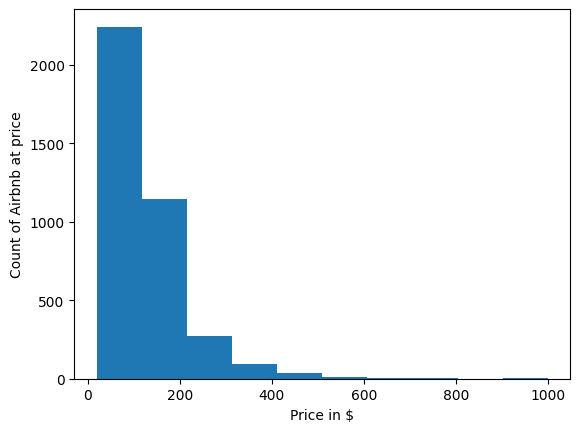

127.97616553169199


Text(0, 0.5, 'Count of Airbnb at price')

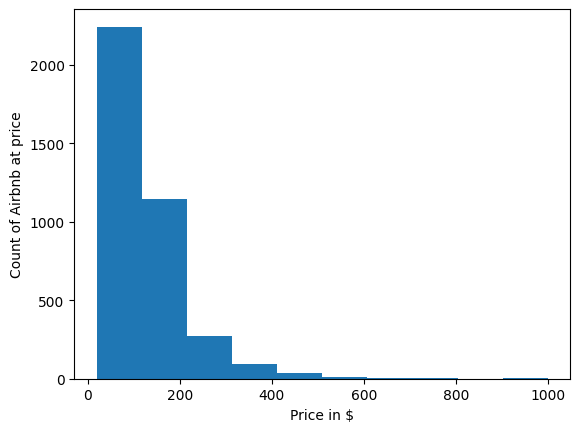

In [5]:
# Question A: average price of Airbnb Seattle
avg_price = df_subset.price.mean() # calculate average
print(avg_price)

# Question B: plot distribution of prices
plt.hist(df_subset.price)
plt.xlabel('Price in $')
plt.ylabel('Count of Airbnb at price')

#### Question C: What is the distribution of the summary rating score for stays in Seattle Airbnbs?
The histogram shows that the majority of rankings are 90-100% summary ratings. Seattle Airbnbs are ranked high! (Or customers leave good reviews if they had a good stay and don't comment if the stay wasn't great.)

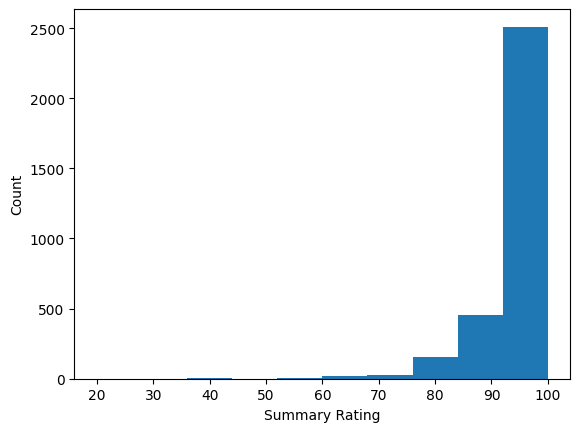
#### Question D: Are vistors leaving better reviews for more expensive stays?
There is a trend! The more expensive the stay, the more likely there is a higher summary rating.

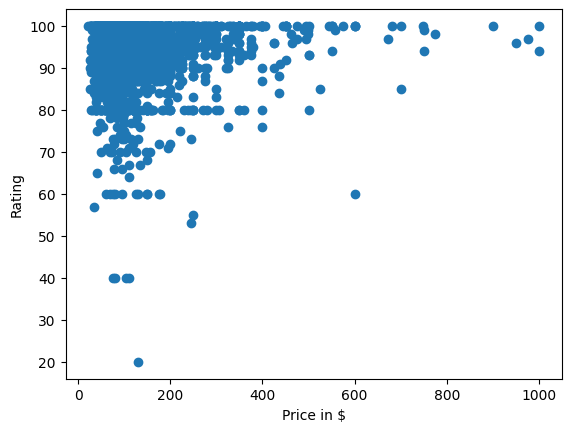

Text(0.5, 0, 'Summary Rating')

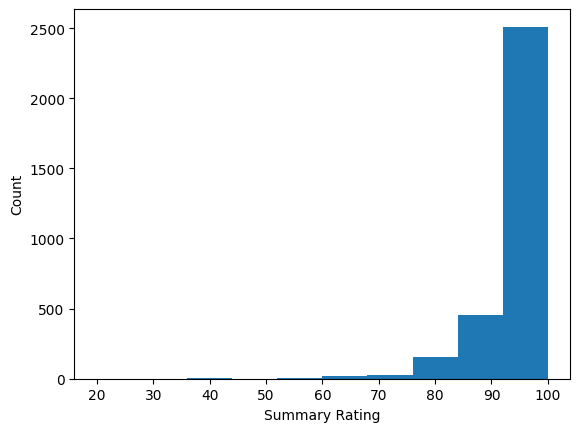

In [8]:
# look at distribution of ratings
plt.hist(df_subset.rating) 
plt.ylabel('Count')
plt.xlabel('Summary Rating')

Text(0, 0.5, 'Rating')

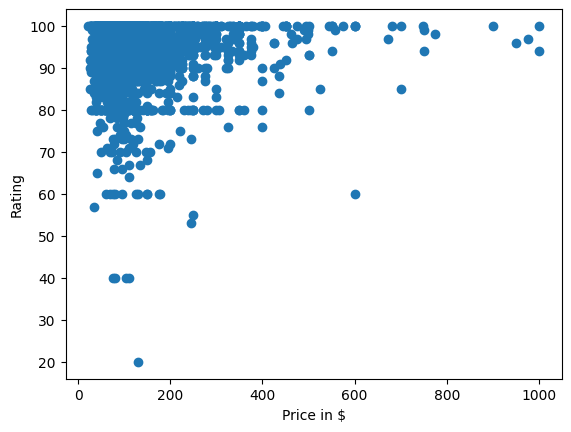

In [9]:
# Plot price vs rankings
plt.scatter(df_subset.price, df_subset.rating)
plt.xlabel('Price in $')
plt.ylabel('Rating')

#### Summary: There are more ratings at lower priced stays, but higher priced stays do have consistently higher ratings. 
#### Question E: Does the availability show us anything else about the bookings?
Lots of Seattle Airbnbs have availability!

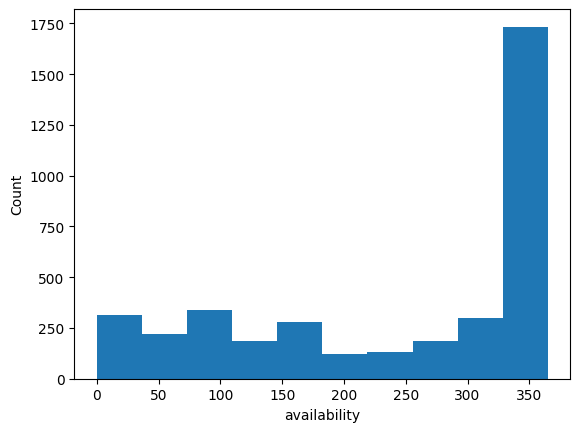

Text(0, 0.5, 'Count')

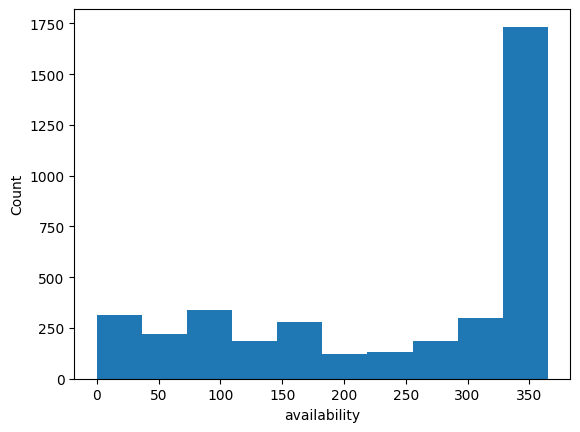

In [10]:
# look at the availability over the next 365 and determine if price influences availability
plt.hist(df_subset.avail365) # this histogram doesn't reveal much other than that there are plenty of Airbnb's with availability!
plt.xlabel('availability')
plt.ylabel('Count')

#### Question F: Does price affect availability? 
There's not a discernable trend between availability and price.

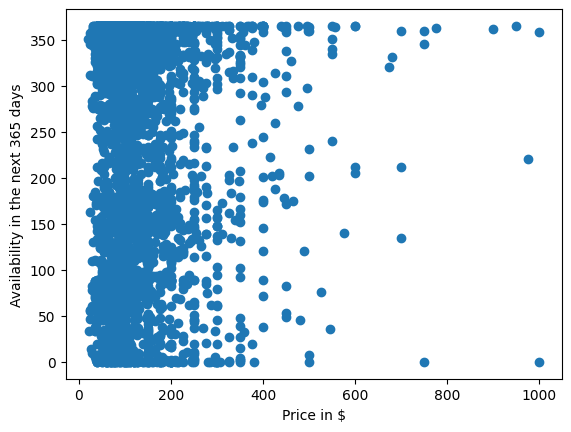

Text(0.5, 0, 'Price in $')

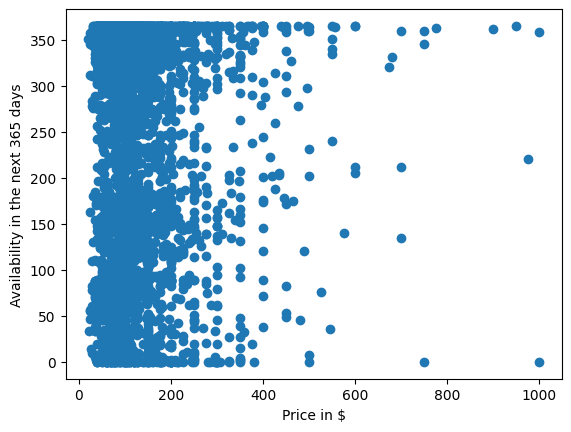

In [11]:
# plot price and availability
plt.scatter(df_subset.price, df_subset.avail365)
plt.ylabel('Availability in the next 365 days')
plt.xlabel('Price in $')

## Data Preperation

Prepare the data to predict the price of the Airbnb based on the listing data.

In [13]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
'''
    for cat_col in cat_cols: # loop through all categorical columns
        try:
            # create dummies
            dummies = pd.get_dummies(df[cat_col], dummy_na = dummy_na, drop_first = True, prefix = cat_col, prefix_sep = '_')
            # drop original column
            df = df.drop(columns = [cat_col])
            # add in dummies columns
            df = df.join(dummies)
        except:
            continue
    return df

In [15]:
# clean up price as done before but to main dataframe as update is needed
# this is reproduced from above for main dataframe updates
df['price'] = df.price.str.replace("$","")
df['price'] = df.price.str.replace(",","").astype(float)
# remove label columns
df = df.drop(columns = ['id','listing_url','scrape_id','last_scraped'])

## Model Fitting

In [14]:
def clean_fit_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    # Drop the rows with missing response values
    df = df.dropna(subset = [response_col], axis = 0)
    # Drop columns with NaN for all the values
    df = df.dropna(how = 'all', axis = 1)
    # Use create_dummy_df to dummy categorical columns
    df = create_dummy_df(df, cat_cols, dummy_na)
    # Fill the mean of the column for any missing values Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)
    # Split your data into a X matrix and a response vector y
    y = df[response_col]
    X = df.drop(columns=[response_col], axis = 1)
    # Create training and test sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state)
    # Instantiate a LinearRegression or RandomForestRegressor model with normalized data
    lm_model = RandomForestRegressor()
    # Fit your model to the training data
    lm_model.fit(X_train, y_train)
    # Predict the response for the training data and the test data
    y_train_pred = lm_model.predict(X_train)
    y_test_pred = lm_model.predict(X_test)
    # Obtain an rsquared value for both the training and test data
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, df


#### Use model function

In [ ]:
# create categorical columns list
cat_cols_lst = list(df.select_dtypes(include = ['object']))
# use function to fit model
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, df_cleaned = clean_fit_mod(df, 'price', cat_cols_lst, dummy_na=False)

In [173]:
# examine results
print('train score: ',train_score,' & ' ,'test score: ', test_score)

train score:  0.9435875949171488  &  test score:  0.6403060278749599


#### The above indicates the model is overfit; it does really well on our subset but falls short in predicting during testing. It's likely that a linear model isn't the best fit here, but we will improve it in the next step.

In [174]:
# subset list of variables to include
df_reduced = df[['price','host_is_superhost','bathrooms','bedrooms',
                'street','zipcode', 'market', 'property_type', 'room_type', 'accommodates',
                'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'security_deposit',
                'cleaning_fee',  'minimum_nights',
                'maximum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating',
                'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'instant_bookable',
                'cancellation_policy', 'require_guest_profile_picture',
                'require_guest_phone_verification', 'calculated_host_listings_count',
                'reviews_per_month']]

#### Try modeling with a smaller dataset to see if that can improve the fit.

In [176]:
# create categorical columns list
cat_cols_lst = list(df_reduced.select_dtypes(include = ['object']))
# use function to fit model
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, df_reduced_cleaned = clean_fit_mod(df_reduced, 'price', cat_cols_lst, dummy_na=False)

In [177]:
print('train score: ',train_score,' & ' ,'test score: ', test_score) # examine results

train score:  0.9357109582400278  &  test score:  0.6160821820503464


#### Reducing the dataset leads to less overfitting of the model, but doesn't result in a better model in regards to the test score outcome. More modeling is necessary to fully capture and predict the price of the Airbnb in Seattle.